In [2]:
import hvplot.xarray

import sys

sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres")
import xapres as xa
import matplotlib.pyplot as plt
import xarray as xr
from datatree import DataTree
import numpy as np

In [4]:
def load_zarr(f):
    return xr.open_dataset(f, engine = 'zarr', chunks = {})
LTG = load_zarr('/Users/jkingslake/Documents/science/ApRES/TG_apres/notebooks/zarrs/LTG_stacked.zarr').load()
dLTG = LTG.profile_stacked.displacement_timeseries().compute()

In [5]:
dt_years = ((dLTG.profile_time.sel(shot_number=2) - dLTG.profile_time.sel(shot_number=1)) / np.timedelta64(1,'D') / 365.25).rename('dt_years')
dt_years.attrs['units'] = 'years'
dt_years.attrs['long_name'] = 'Time between shots'
dt_years.attrs['description'] = 'Time in years between shots used in each measurement of displacement, vertical velocity, etc. dt_years[i] is the time between shot [j] and shot [j-1]'

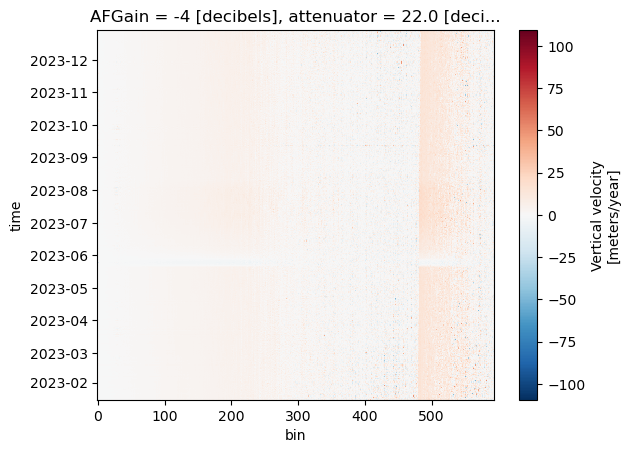

In [14]:
velocity = (dLTG.displacement / dt_years).rename('velocity')
velocity.attrs['units'] = 'meters/year'
velocity.attrs['long_name'] = 'Vertical velocity'
velocity.plot()

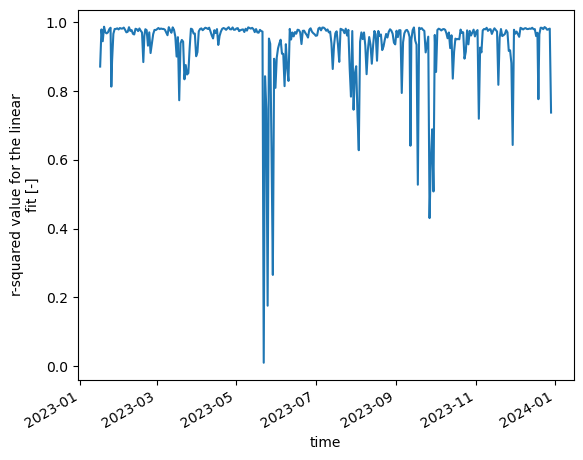

In [47]:
def addStrainRates(self, lower_limit_on_fit = 800):
    data_cropped = self.velocity\
            .squeeze()\
            .where(self.velocity.bin_depth < lower_limit_on_fit)
    
    fit_ds = data_cropped.polyfit('bin', 1, full = True)
            
    strain_rate = fit_ds.sel(degree = 1, drop =True).polyfit_coefficients.rename('strain_rate')
    surface_intercept =  fit_ds.sel(degree = 0, drop =True).polyfit_coefficients.rename('surface_intercept') 

    strain_rate.attrs['units'] = '1/year'
    strain_rate.attrs['long_name'] = f"vertical strain rate in upper {lower_limit_on_fit} m"
    surface_intercept.attrs['units'] = 'meters/year'
    surface_intercept.attrs['long_name'] = 'vertical velocity at the surface from the linear fit'
    
    y_mean = data_cropped.mean(dim = 'bin')
    SS_tot = ((data_cropped - y_mean)**2).sum(dim = 'bin')
    R2 = (1 - (fit_ds.polyfit_residuals/SS_tot)).rename('r_squared')
    R2.attrs['long_name'] = 'r-squared value for the linear fit'
    R2.attrs['units'] = '-'   
    
    return xr.merge([self, strain_rate, surface_intercept, R2])


xr.Dataset.addStrainRates = addStrainRates

dLTG_ezz = xr.merge([dLTG, velocity]).addStrainRates()
dLTG_ezz.r_squared.plot()

In [23]:
lower_limit_on_fit = 800
da = dLTG.displacement.squeeze().where(dLTG.displacement.bin_depth < lower_limit_on_fit)
ezzLTG = da.polyfit('bin', 1, full=True)
ezzLTG

<xarray.Dataset>
Dimensions:               (degree: 2, time: 350)
Coordinates:
  * degree                (degree) int64 1 0
  * time                  (time) datetime64[ns] 2023-01-16T12:51:57.500000 .....
Data variables:
    bin_matrix_rank       int64 2
    bin_singular_values   (degree) float64 1.366 0.3665
    polyfit_coefficients  (degree, time) float64 6.872e-05 ... 0.0001707
    polyfit_residuals     (time) float64 0.0003985 5.19e-05 ... 0.001216

In [30]:
y_mean = da.mean(dim = 'bin')
SS_tot = ((da - y_mean)**2).sum(dim = 'bin')
R2 = 1 - (ezzLTG.polyfit_residuals/SS_tot)
R2

<xarray.DataArray (time: 350)>
array([0.8713641 , 0.97942396, 0.94502682, 0.98727678, 0.97076288,
       0.9679927 , 0.9710211 , 0.97996804, 0.9843374 , 0.81304196,
       0.88788688, 0.96673422, 0.98064523, 0.98092485, 0.98256159,
       0.97940233, 0.98349065, 0.98186914, 0.98205135, 0.98479132,
       0.97835137, 0.97101109, 0.97250004, 0.98592561, 0.97509275,
       0.97759507, 0.96685149, 0.96468841, 0.98140855, 0.98008868,
       0.9746303 , 0.98226744, 0.97555886, 0.97054541, 0.88443078,
       0.96031763, 0.97995199, 0.9773223 , 0.93221528, 0.97097514,
       0.91073897, 0.93755383, 0.96568387, 0.97805326, 0.97760088,
       0.98026227, 0.98361164, 0.98039946, 0.98205389, 0.98082512,
       0.98088634, 0.97860337, 0.97021914, 0.9625682 , 0.98603942,
       0.97706618, 0.9697049 , 0.98545587, 0.97817795, 0.95879807,
       0.90051303, 0.95688242, 0.77334442, 0.93921189, 0.94883612,
       0.94392811, 0.83429622, 0.87579922, 0.84825518, 0.85225164,
       0.92444962, 0.98159302, 0.97972305, 0.96769873, 0.96754727,
       0.90140001, 0.9133115 , 0.97381883, 0.9806441 , 0.98246551,
       0.97713933, 0.98061458, 0.98431661, 0.98313195, 0.98086564,
       0.98450225, 0.97369585, 0.96183453, 0.95323674, 0.97720298,
       0.96889332, 0.98045539, 0.93434903, 0.96056936, 0.97320024,
       0.98114905, 0.98346987, 0.98183076, 0.97827476, 0.98257131,
...
       0.9780735 , 0.97529118, 0.91253087, 0.93557058, 0.95840273,
       0.43043   , 0.59822114, 0.68880782, 0.50792586, 0.96335212,
       0.85579074, 0.97769529, 0.9815869 , 0.97984099, 0.97644712,
       0.97962246, 0.98058053, 0.97820975, 0.96833621, 0.95378279,
       0.97051312, 0.92513687, 0.96240671, 0.83629591, 0.91449707,
       0.95262601, 0.95053847, 0.95180052, 0.95068989, 0.97901303,
       0.96902269, 0.97102322, 0.89444533, 0.91452133, 0.97675232,
       0.93603753, 0.97531182, 0.96174453, 0.97028811, 0.9788078 ,
       0.95910372, 0.97308127, 0.9774797 , 0.71962277, 0.92650561,
       0.91264047, 0.97659596, 0.98059724, 0.97975765, 0.98420307,
       0.97527048, 0.97949076, 0.97998607, 0.96636666, 0.97562822,
       0.98268226, 0.97796857, 0.9733149 , 0.8182722 , 0.95606007,
       0.98052189, 0.96008166, 0.96268785, 0.9661138 , 0.97731703,
       0.97099544, 0.91691216, 0.91866824, 0.88145835, 0.64325377,
       0.97846209, 0.96685712, 0.97321811, 0.96528329, 0.95793282,
       0.98410636, 0.98220318, 0.97933404, 0.98230852, 0.98319907,
       0.98050715, 0.98071877, 0.9819743 , 0.98115822, 0.98429965,
       0.98011956, 0.98038872, 0.95997735, 0.96969067, 0.77645884,
       0.96515171, 0.98434028, 0.98401903, 0.98020809, 0.98633697,
       0.98361261, 0.97852151, 0.97985601, 0.98178659, 0.73750876])
Coordinates:
  * time         (time) datetime64[ns] 2023-01-16T12:51:57.500000 ... 2023-12...
    AFGain       int64 -4
    attenuator   float64 22.0
    orientation  (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'